In [25]:
import tensorflow as tf
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [26]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [34]:
df = pd.read_csv('../Data/Dataset_v3.csv')


#Dropped Glucose
df = df.drop('Glucose', 1)

#Dropped SEQN
df = df.drop('SEQN', 1)

print "\n"
column_names = list(df)
print column_names

print "\n"
print "Unclean label counts:"
print df.groupby('Diabetes').size()

# data cleanup removing rows which have 0,7,9,NaN in the label
df = df[df.Diabetes != 0]
df = df[df.Diabetes != 7]
df = df[df.Diabetes != 9]
df = df[np.isfinite(df['Diabetes'])]

# dropping all NaN in the dataframe with 0
df.dropna(inplace=True)

print "\n"
print "Cleaned label counts:"
print df.groupby('Diabetes').size()


#separating features and labels
features = df.iloc[:, 0:-1]
label = df.iloc[:,-1]

print "\n"
print "Columns in the features"
column_names = list(features)
print column_names

#normalizing features - unnormalized also results in similar results
normalized_features = (features - features.mean())/features.std()



['GENDER', 'AGE', 'WIEGHT', 'HIEGHT', 'BMI', 'Waist', 'Race_ethinicity', 'Physical_activity', 'Diabetes']


Unclean label counts:
Diabetes
0.0        7
1.0     1576
2.0    27798
3.0      214
7.0        1
9.0       12
dtype: int64


Cleaned label counts:
Diabetes
1.0     1455
2.0    25361
3.0      201
dtype: int64


Columns in the features
['GENDER', 'AGE', 'WIEGHT', 'HIEGHT', 'BMI', 'Waist', 'Race_ethinicity', 'Physical_activity']


### Formatting input for Machine Learning

In [35]:
# X = features.as_matrix()
X = normalized_features.as_matrix()

# lb = preprocessing.LabelBinarizer()
# Y = lb.fit_transform(label.as_matrix())
Y = label.as_matrix()

print "Shape of the matrices"
print X.shape
print Y.shape

print "\n"
print "Total unique counts by labels"
print np.unique(Y, return_counts=True)

# Y = label_binarize(Y, classes=[1, 2, 3])

# 70% training and 30% test 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print "\n"
print "Total unique counts by labels for training and testing"
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print np.unique(y_train, return_counts=True)
print np.unique(y_test, return_counts=True)

Shape of the matrices
(27017, 8)
(27017,)


Total unique counts by labels
(array([ 1.,  2.,  3.]), array([ 1455, 25361,   201]))


Total unique counts by labels for training and testing
(18911, 'train sequences')
(8106, 'test sequences')
(array([ 1.,  2.,  3.]), array([ 1012, 17754,   145]))
(array([ 1.,  2.,  3.]), array([ 443, 7607,   56]))


#### Comparision with Decision Trees and Random Forest 
RF number of trees - 50


Decision Tree
              precision    recall  f1-score   support

    Daibetic       0.21      0.23      0.22       443
      Normal       0.95      0.94      0.95      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.90      0.90      0.90      8106

Confusion matrix, without normalization
[[ 103  326   14]
 [ 380 7168   59]
 [   9   47    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.896989884037
Precision:  0.903463769571
Recall:  0.896989884037


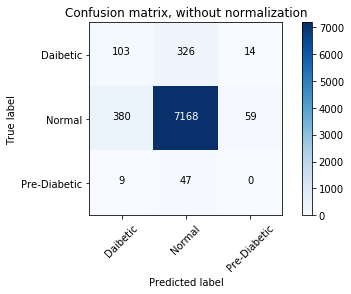

In [36]:
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# These are the tuned paramters

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def decision_tree(feat_train, feat_test, label_train, label_test):
    clf = tree.DecisionTreeClassifier(class_weight=None,
                                      criterion='gini', splitter='best')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Decision Tree')
accuracy,precision,recall = decision_tree(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


In [39]:
def random_forest(feat_train, feat_test, label_train, label_test, num_estimators):
    clf = RandomForestClassifier(n_estimators=num_estimators, max_features=None)

    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

#### Random Forest with 50 trees

Random forest
              precision    recall  f1-score   support

    Daibetic       0.29      0.09      0.14       443
      Normal       0.94      0.99      0.96      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.90      0.93      0.91      8106

Confusion matrix, without normalization
[[  39  403    1]
 [  93 7513    1]
 [   1   55    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.93165556378
Precision:  0.900544913872
Recall:  0.93165556378


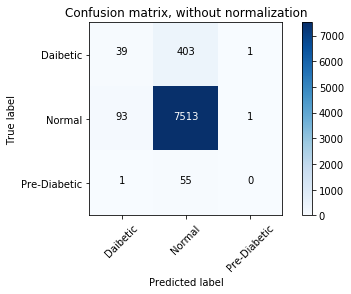

In [40]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 50)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 500 trees

Random forest
              precision    recall  f1-score   support

    Daibetic       0.28      0.06      0.10       443
      Normal       0.94      0.99      0.97      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.90      0.93      0.91      8106

Confusion matrix, without normalization
[[  28  415    0]
 [  72 7535    0]
 [   1   55    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.933012583272
Precision:  0.898492447108
Recall:  0.933012583272


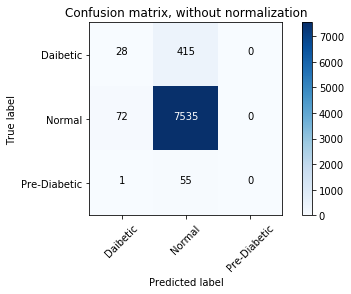

In [41]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 1000 trees

Random forest
              precision    recall  f1-score   support

    Daibetic       0.21      0.03      0.05       443
      Normal       0.94      0.99      0.97      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.89      0.93      0.91      8106

Confusion matrix, without normalization
[[  12  431    0]
 [  46 7560    1]
 [   0   56    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.934122871947
Precision:  0.892953827984
Recall:  0.934122871947


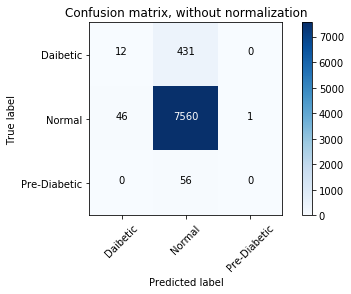

In [12]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 1000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 10000 trees

Random forest
              precision    recall  f1-score   support

    Daibetic       0.30      0.07      0.12       443
      Normal       0.94      0.99      0.97      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.90      0.93      0.91      8106

Confusion matrix, without normalization
[[  32  411    0]
 [  72 7535    0]
 [   1   55    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.933506044905
Precision:  0.900438829923
Recall:  0.933506044905


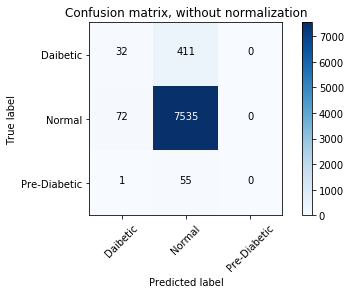

In [42]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 10000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

Logistic Regression
              precision    recall  f1-score   support

    Daibetic       0.29      0.00      0.01       443
      Normal       0.94      1.00      0.97      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.90      0.94      0.91      8106

Confusion matrix, without normalization
[[   2  441    0]
 [   5 7602    0]
 [   0   56    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.938070565014
Precision:  0.896467222318
Recall:  0.938070565014


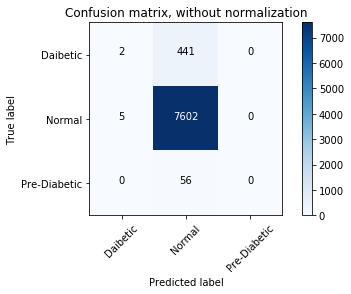

In [43]:
def log_reg(feat_train, feat_test, label_train, label_test):
    clf = linear_model.LogisticRegression()
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Logistic Regression')
accuracy,precision,recall = log_reg(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


SVM
              precision    recall  f1-score   support

    Daibetic       0.00      0.00      0.00       443
      Normal       0.94      1.00      0.97      7607
Pre-Diabetic       0.00      0.00      0.00        56

 avg / total       0.88      0.94      0.91      8106

Confusion matrix, without normalization
[[   0  443    0]
 [   0 7607    0]
 [   0   56    0]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.938440661239
Precision:  0.880670874666
Recall:  0.938440661239


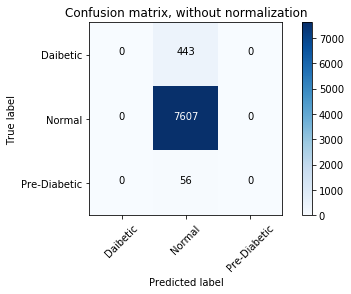

In [11]:
from sklearn.svm import SVC
def svm(feat_train, feat_test, label_train, label_test):
    clf = SVC(gamma=.2)
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('SVM')
accuracy,precision,recall = svm(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall